In [2]:
# Step 1: Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

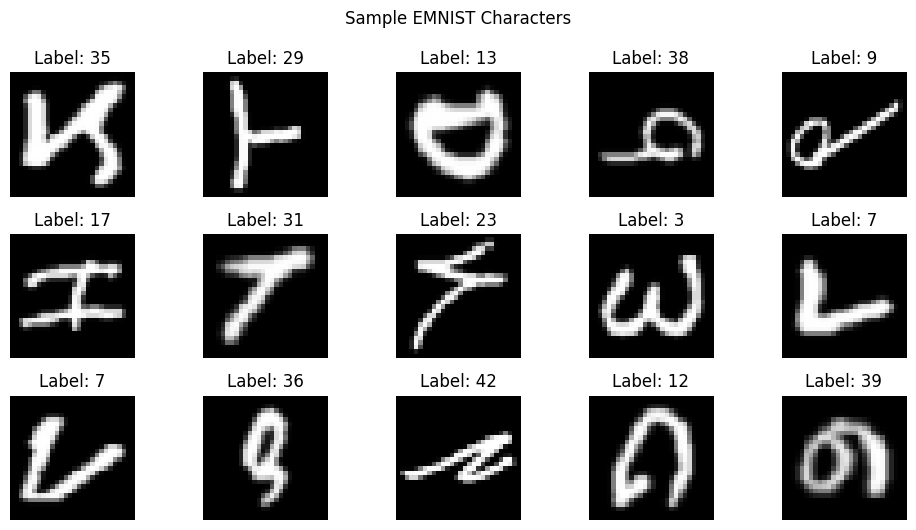

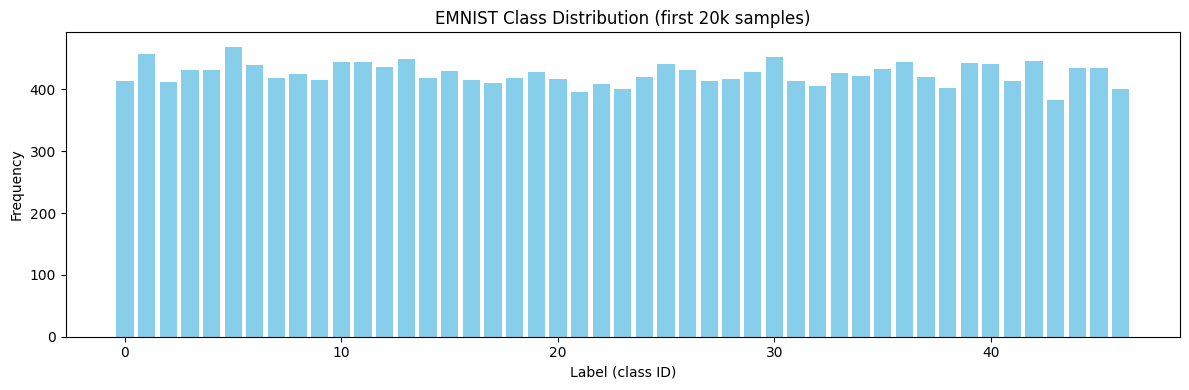

Number of EMNIST classes: 47


In [3]:
# Step 2: Load EMNIST
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/balanced',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True)

NUM_CLASSES = ds_info.features['label'].num_classes
IMG_SIZE = ds_info.features['image'].shape[0]

def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.rot90(image, k=3)
    return image, label

BATCH_SIZE = 128

ds_train = (ds_train
            .map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
            .cache()
            .shuffle(10_000)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

ds_test = (ds_test
           .map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH_SIZE)
           .cache()
           .prefetch(tf.data.AUTOTUNE))


# Show a sample of 15 EMNIST images after rotation
plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(ds_train.unbatch().take(15)):
    plt.subplot(3, 5, i + 1)
    plt.imshow(tf.image.rot90(image, k=1).numpy().squeeze(), cmap='gray')
    plt.title(f"Label: {label.numpy()}")
    plt.axis('off')
plt.tight_layout()
plt.suptitle("Sample EMNIST Characters", y=1.05)
plt.show()

# Extract label distribution from a subset of training data
from collections import Counter

label_counts = Counter()

for _, label in tfds.as_numpy(ds_train.unbatch().take(20000)):
    label_counts[int(label)] += 1

plt.figure(figsize=(12,4))
plt.bar(label_counts.keys(), label_counts.values(), color="skyblue")
plt.title("EMNIST Class Distribution (first 20k samples)")
plt.xlabel("Label (class ID)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

print("Number of EMNIST classes:", NUM_CLASSES)


In [4]:
# Step 3: Extract data for Logistic Regression and Augmentation
X_train_np = []
y_train_np = []
X_test_np = []
y_test_np = []

for img, lbl in tfds.as_numpy(ds_train.unbatch().take(10000)):
    X_train_np.append(img)
    y_train_np.append(lbl)
for img, lbl in tfds.as_numpy(ds_test.unbatch().take(2000)):
    X_test_np.append(img)
    y_test_np.append(lbl)

X_train_np = np.array(X_train_np).reshape(-1, 28*28)
X_test_np = np.array(X_test_np).reshape(-1, 28*28)
y_train_np = np.array(y_train_np)
y_test_np = np.array(y_test_np)


In [5]:
# Step 4: Logistic Regression Baseline
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_np, y_train_np)
y_pred_log = logreg.predict(X_test_np)
print("Logistic Regression Accuracy:", accuracy_score(y_test_np, y_pred_log))
print("Logistic Regression Report:")
print(classification_report(y_test_np, y_pred_log, digits=4))

Logistic Regression Accuracy: 0.6175
Logistic Regression Report:
              precision    recall  f1-score   support

           0     0.5217    0.5217    0.5217        46
           1     0.3265    0.5161    0.4000        31
           2     0.5789    0.6875    0.6286        32
           3     0.8542    0.8723    0.8632        47
           4     0.5294    0.6136    0.5684        44
           5     0.6304    0.6444    0.6374        45
           6     0.7111    0.7805    0.7442        41
           7     0.7111    0.8649    0.7805        37
           8     0.7143    0.6667    0.6897        45
           9     0.6471    0.5366    0.5867        41
          10     0.5306    0.5532    0.5417        47
          11     0.7500    0.5625    0.6429        48
          12     0.6949    0.8200    0.7523        50
          13     0.5429    0.5000    0.5205        38
          14     0.8125    0.6341    0.7123        41
          15     0.5135    0.5135    0.5135        37
          16    

In [6]:
# Step 5: Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [7]:
# Step 6: CNN Model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

c:\Machine Learning\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,287 (1.87 MB)

 Trainable params: 490,287 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Step 7: Prepare Augmented Dataset
aug_ds_train = ds_train.map(lambda x, y: (tf.image.random_flip_left_right(x), y))

In [9]:
# Enhancements: Callbacks and Regularization
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
model_ckpt = ModelCheckpoint('best_emnist_model.keras', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
callbacks = [early_stop, reduce_lr, model_ckpt]

In [10]:
# Step 8: Train CNN
history = model.fit(aug_ds_train,
                    validation_data=ds_test,
                    epochs=25,
                    callbacks=callbacks)

Epoch 1/25
882/882 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.3966 - loss: 2.1470 - val_accuracy: 0.7615 - val_loss: 0.7478 - learning_rate: 0.0010
Epoch 2/25
882/882 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.6901 - loss: 0.9811 - val_accuracy: 0.7915 - val_loss: 0.6374 - learning_rate: 0.0010
Epoch 3/25
882/882 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.7345 - loss: 0.8274 - val_accuracy: 0.8157 - val_loss: 0.5650 - learning_rate: 0.0010
Epoch 4/25
882/882 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.7572 - loss: 0.7458 - val_accuracy: 0.8220 - val_loss: 0.5360 - learning_rate: 0.0010
Epoch 5/25
882/882 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.7726 - loss: 0.6932 - val_accuracy: 0.8273 - val_loss: 0.5110 - learning_rate: 0.0010
Epoch 6/25
882/882 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.7850 - loss: 0.6550 - val_accuracy: 0.8351 - val_loss: 0.4916 - learning_rate: 0.0010
Epoch 7/25
882/882 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.7897 - l

In [11]:
# Step 9: Evaluate CNN
test_loss, test_acc = model.evaluate(ds_test)
print(f"CNN Test Accuracy: {test_acc:.4f}")

147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8600 - loss: 0.4203
CNN Test Accuracy: 0.8580


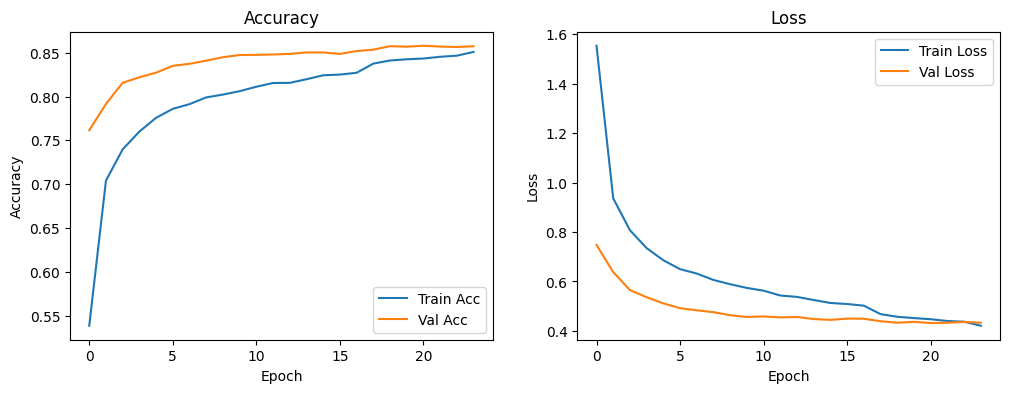

In [12]:
# Step 10: Accuracy and Loss Plots
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Step 11: Classification Report for CNN
y_true = []
y_pred = []
for images, labels in ds_test:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("CNN Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

CNN Classification Report:
              precision    recall  f1-score   support

           0     0.6536    0.7500    0.6985       400
           1     0.5800    0.5800    0.5800       400
           2     0.8744    0.8700    0.8722       400
           3     0.9525    0.9525    0.9525       400
           4     0.9335    0.8775    0.9046       400
           5     0.9504    0.8625    0.9043       400
           6     0.9152    0.9175    0.9164       400
           7     0.9686    0.9250    0.9463       400
           8     0.9248    0.9525    0.9384       400
           9     0.6457    0.8200    0.7225       400
          10     0.9651    0.9675    0.9663       400
          11     0.9314    0.9500    0.9406       400
          12     0.9322    0.9625    0.9471       400
          13     0.8828    0.8850    0.8839       400
          14     0.9571    0.9475    0.9523       400
          15     0.6721    0.5125    0.5816       400
          16     0.9163    0.9300    0.9231       400


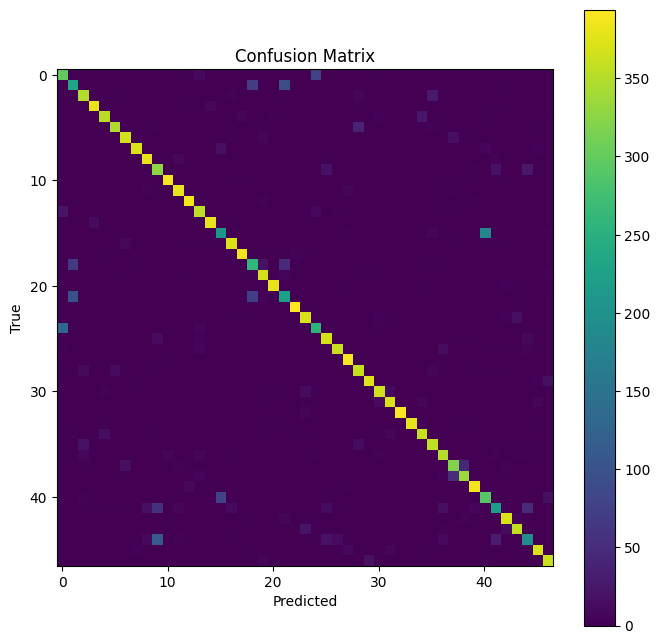

In [14]:
# Step 12 – Confusion Matrix
# Build arrays of true / pred labels

y_true = []
y_pred = []

for images, labels in ds_test:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES))

plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.show()

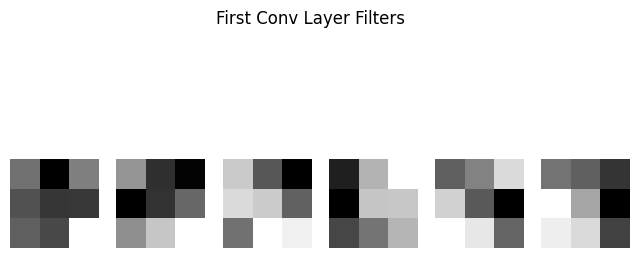

In [15]:
# Step 13: Visualize Filters from First Conv2D Layer
filters, _ = model.layers[0].get_weights()
filters = (filters - filters.min()) / (filters.max() - filters.min())
plt.figure(figsize=(8,4))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(filters[:, :, 0, i], cmap='gray')
    plt.axis('off')
plt.suptitle('First Conv Layer Filters')
plt.show()

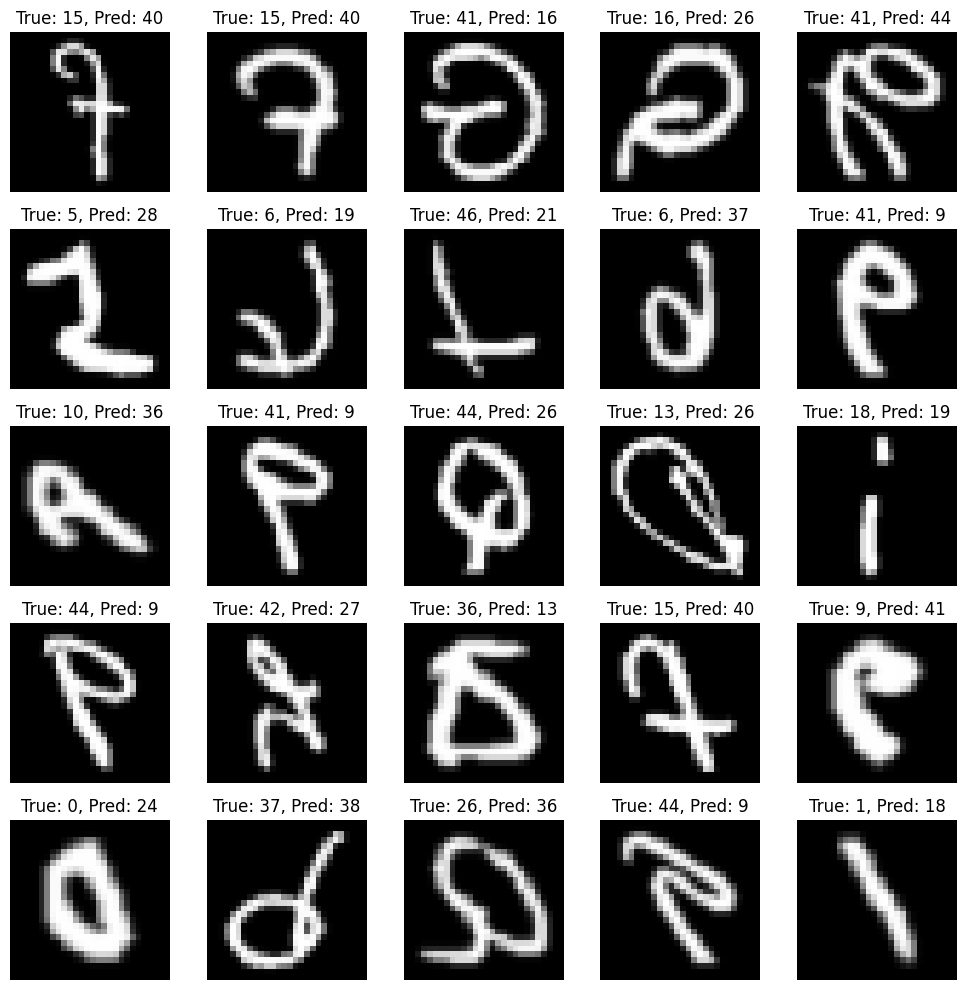

In [16]:
# Step 14: Misclassified Visualization
y_pred_classes = np.array(y_pred)  # Convert y_pred to a numpy array
y_test = y_test_np  # Use y_test_np as y_test
misclassified = np.where(y_pred_classes[:len(y_test)] != y_test)[0][:25]
plt.figure(figsize=(10, 10))
for i, idx in enumerate(misclassified):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_test_np[idx].reshape(28, 28), cmap='gray')  # Use X_test_np for the images
    plt.title(f"True: {y_test[idx]}, Pred: {y_pred_classes[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Step 15: F1 Score
from sklearn.metrics import f1_score

# Ensure y_test_trimmed and y_pred_classes have the same length
y_pred_trimmed = y_pred_classes[:len(y_test)]

f1 = f1_score(y_test, y_pred_trimmed, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")

Weighted F1 Score: 0.8536
